#Projet SD 201

Barthélemy Bulteau, Denis Fouchard, Loïc Larroche, Barthélemy Paléologue

Dataset : https://www.kaggle.com/datasets/jackogozaly/data-science-and-stem-salaries

## Abstact

The goal of this project is to make prediction about salaries in the field of tech industries. More precisely we want to be able to predict the average wage of a given worker knowing a set of features including race, gender and education. We will study the impact of these socially important features in the accuracy of the result and try to draw conclusions. Test


In [ ]:
import pandas as pd
import numpy as np
import random
import scipy
import sklearn
from matplotlib import pyplot as plt
plt.style.use("seaborn")
import seaborn as sns
from tqdm import tqdm

## Dataset

Source : https://www.kaggle.com/datasets/jackogozaly/data-science-and-stem-salaries

We will base our work on this dataset from kaggle which holds 50k+ entries about salaries in the field of tech companies in relation to many features including race, gender and education.

In [ ]:
df = pd.read_csv('salary.csv')
print(f"We have loaded {df.shape[0]} entries")
df.head()

We have loaded 62642 entries


,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,...,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education
0,6/7/2017 11:33:27,Oracle,L3,Product Manager,127000,"Redwood City, CA",1.50000,1.50000,NaN,107000.00000,...,0,0,0,0,0,0,0,0,NaN,NaN
1,6/10/2017 17:11:29,eBay,SE 2,Software Engineer,100000,"San Francisco, CA",5.00000,3.00000,NaN,0.00000,...,0,0,0,0,0,0,0,0,NaN,NaN
2,6/11/2017 14:53:57,Amazon,L7,Product Manager,310000,"Seattle, WA",8.00000,0.00000,NaN,155000.00000,...,0,0,0,0,0,0,0,0,NaN,NaN
3,6/17/2017 0:23:14,Apple,M1,Software Engineering Manager,372000,"Sunnyvale, CA",7.00000,5.00000,NaN,157000.00000,...,0,0,0,0,0,0,0,0,NaN,NaN
4,6/20/2017 10:58:51,Microsoft,60,Software Engineer,157000,"Mountain View, CA",5.00000,3.00000,NaN,0.00000,...,0,0,0,0,0,0,0,0,NaN,NaN


## Data cleaning and format

The dataset needs cleaning before we can use it for our research. This section aims at describing the necessary steps taken to clean the data and the reasons behind our choices.

### Removing redundant features

First we will remove the features that carry no meaning for our work, or are redundant compared to other features.




In [ ]:
dropped_cols = []

The column `rowNumber` is just another index for the data, hinting at some preprocessing done on it in the past. The order of the data is not relevant for us, we can drop it.

In [ ]:
dropped_cols += ["rowNumber"]

The column `otherdetails` contains information that are highly specific to each datarow, and it does not seem possible to automate its exploitation. It would need to be done by hand on a dataset of 50k+ data. We choose to drop it.

In [ ]:
dropped_cols += ["otherdetails"]

As the dataset provides a feature `Education`, we do not need `Masters_Degree`, `Bachelors_Degree`, `Doctorate_Degree`, `Highschool`, `Some_College` which are redundant.


In [ ]:
dropped_cols += ["Masters_Degree", "Bachelors_Degree", "Doctorate_Degree", "Highschool", "Some_College"]


For the same reason, we already have a feature `Race`, therefore we can drop the redundant `Race_Asian`, `Race_White`, `Race_Two_Or_More`, `Race_Black`, `Race_Hispanic`.

In [ ]:
dropped_cols += ["Race_Asian", "Race_White", "Race_Two_Or_More", "Race_Black", "Race_Hispanic"]


The column `level` is redundant as we already have the title of the job and the total years of experience of each employee. We will drop it as well

In [ ]:
dropped_cols += ["level"]

The column `tag` seem to only retain the speciality of some of the employees. This gives more context for the feature `title` but we are studying the impact of race, gender and education, not the impact of the speciality.

In [ ]:
dropped_cols += ["tag"]

The feature `location` can be used to extract the state from where it is comming from. Indeed, the state is encoded as the last word of the `location`. We believe the `state` can be used for general predictions as it is a broader feature than `location` and could help us with overfitting further down the line.

In [ ]:
df["state"] = df["location"].apply(lambda location: location.split(" ")[-1])
df["state"].unique()

array(['CA', 'WA', 'Kingdom', 'NY', 'Ireland', 'MD', 'OR', 'India',
       'Belarus', 'DC', 'Canada', 'TX', 'MA', 'LA', 'PA', 'SC', 'Russia',
       'VA', 'CO', 'NE', 'IN', 'WI', 'MN', 'Netherlands', 'Switzerland',
       'Singapore', 'IL', 'Germany', 'NJ', 'Japan', 'AZ', 'Sweden',
       'Australia', 'States', 'Israel', 'Poland', 'OH', 'China', 'NC',
       'Austria', 'Luxembourg', 'FL', 'GA', 'MO', 'Republic', 'RI', 'UT',
       'France', 'Pakistan', 'Zealand', 'Denmark', 'MI', '(SAR)',
       'Africa', 'Spain', 'CT', 'Emirates', 'NM', 'AR', 'VT', 'Hungary',
       'IA', 'Brazil', 'Bulgaria', 'KS', 'NH', 'ID', 'Philippines', 'TN',
       'Indonesia', 'Rico', 'Taiwan', 'DE', 'Romania', 'AL', 'Mexico',
       'NV', 'Rica', 'Islands', 'Vietnam', 'Panama', 'KY', 'Argentina',
       'Norway', 'Moldova', 'Estonia', 'Kenya', 'Turkey', 'Italy',
       'Lithuania', 'Nigeria', 'WV', 'South', 'Ukraine', 'Jordan',
       'Thailand', 'OK', 'Colombia', 'Serbia', 'Portugal', 'Guatemala',
       'Yu

As we can see we have many different states in the dataset, we should only take those where the population is big enough to make our statistical analysis relevant. We will arbitrarily put this limit at 500.

We had 62642 rows.
We now have 55427 rows.


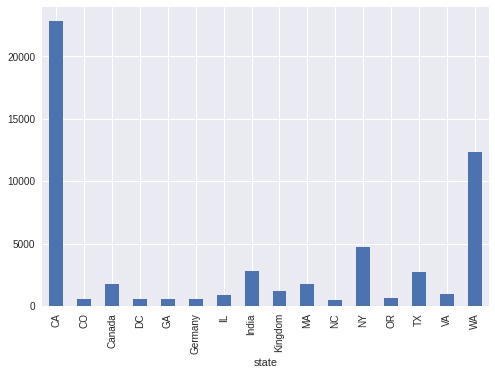

In [ ]:
print(f"We had {df.shape[0]} rows.")
df = df.groupby(["state"]).filter(lambda x: len(x) >= 500)
print(f"We now have {df.shape[0]} rows.")
df.groupby(["state"]).size().plot(kind="bar")

The column `location` comes with another column `cityid`. As the elements of `cityid` are integers and there is a one to one relationship between the two features, we will create a dictionnary of cities using `cityid` as keys. We can also extract the state of the city from `location`, which will give us a broader point of view on the influence of location. Then we can drop `location`.

In [ ]:
dropped_cols += ["location"]
city_from_id = dict(zip(df["cityid"], df["location"]))
cityid_from_name = dict(zip(df["location"], df["cityid"]))

The column `dmaid` represents a feature that is not related to gender, Race or Education. Therefore to limit overfitting we choose to drop it as well.

In [ ]:
dropped_cols += ["dmaid"]

The columns `totalyearlycompensation`, `basesalary`, `stockgrantvalue`, `bonus` are related by the relation `totalyearlycompensation` = `basesalary` + `stockgrantvalue` + `bonus`. As we can see in the graph below, we have some outliers that do not respect that relation. Therefore we will remove the outliers with a tolerance of 1k of difference, then we will only keep `totalyearlycompensation` and drop the other features mentionned.

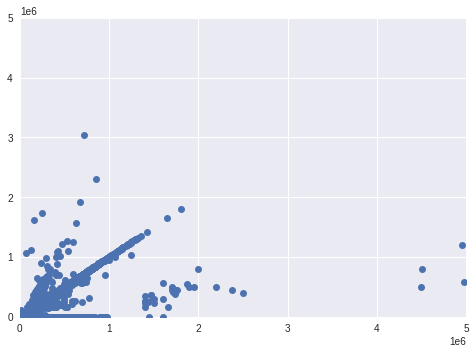

In [ ]:
plt.xlim(0, 5e6)
plt.ylim(0, 5e6)
plt.plot(df["totalyearlycompensation"], df["basesalary"] + df["stockgrantvalue"] + df["bonus"], 'o')

As we can see we only have a handful of aberrant datapoints, we will drop them as they are not numerous.

We had 55427 rows.
We are left with 48478 rows.


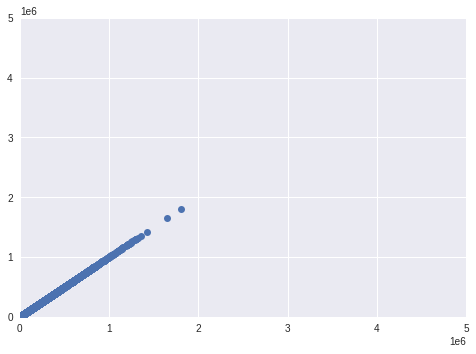

In [ ]:
print(f"We had {df.shape[0]} rows.")
df = df.drop(df[np.abs(df["totalyearlycompensation"] - (df["basesalary"] + df["stockgrantvalue"] + df["bonus"])) > 1e3].index)
print(f"We are left with {df.shape[0]} rows.")

plt.xlim(0, 5e6)
plt.ylim(0, 5e6)
plt.plot(df["totalyearlycompensation"], df["basesalary"] + df["stockgrantvalue"] + df["bonus"], 'o')
plt.show()

In [ ]:
dropped_cols += ["basesalary", "stockgrantvalue", "bonus"]

In [ ]:
df.drop(dropped_cols, axis=1, inplace=True)
df.head()

,timestamp,company,title,totalyearlycompensation,yearsofexperience,yearsatcompany,gender,cityid,Race,Education,state
3,6/17/2017 0:23:14,Apple,Software Engineering Manager,372000,7.00000,5.00000,NaN,7472,NaN,NaN,CA
6,6/22/2017 12:37:51,Microsoft,Software Engineering Manager,300000,15.00000,11.00000,NaN,11521,NaN,NaN,WA
7,6/22/2017 13:55:26,Microsoft,Software Engineer,156000,4.00000,4.00000,NaN,11527,NaN,NaN,WA
13,7/7/2017 22:29:34,Microsoft,Software Engineer,191000,7.00000,7.00000,NaN,11527,NaN,NaN,WA
15,7/16/2017 16:50:46,Amazon,Software Engineer,218000,10.00000,0.00000,NaN,11527,NaN,NaN,WA


### Cleaning the last relevant data

The company names are sometimes written in lower case and sometimes in normal case, to avoid splitting the data for one company, we chose to lower case the entire column `company`

In [ ]:
df["company"] = df["company"].str.lower()

The dataset provides us with the number of years of experience of the workers in their companies. They are given as floats, which won't suit us very well if we want to implement some kind of decision tree down the line. Consequently, we chose to floor all the years of experience to work only with integers. Moreover we will regroup them in tranches of 5 years to smooth out our data.

In [ ]:
df["yearsofexperience"] = df["yearsofexperience"].apply(lambda x: int(x / 5))
df["yearsatcompany"] = df["yearsatcompany"].apply(lambda x: int(x / 5))

We must also check the distribution of `title` in our data, we don't want to keep the titles if we only have a handful of data because we wouldn't be able to draw any conclusion.

We will remove 4122 entries


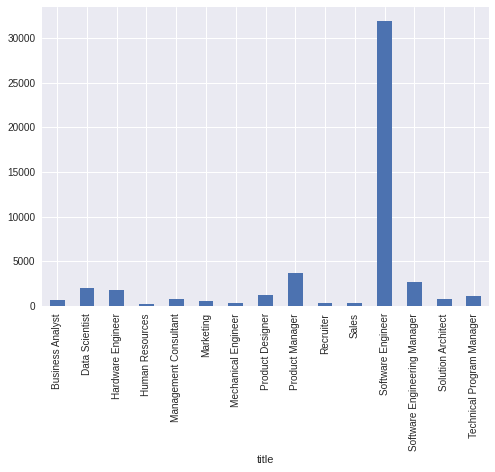

In [ ]:
titles = df["title"].unique()
dropped_titles = []
amount_removed = 0
for title in titles:
  subset = df[df['title'] == title]
  population = subset.shape[0]
  if population < 1000:
    dropped_titles += [title]
    amount_removed += subset.shape[0]
  #print(f"We have {population} {title}s")

df.groupby(["title"]).size().plot(kind="bar")

print(f"We will remove {amount_removed} entries")

They are all different, we do not have issues with the case so we can go on. Yet we see that many of the categories are not well populated, we will remove all titles that have less than 1000 data points.

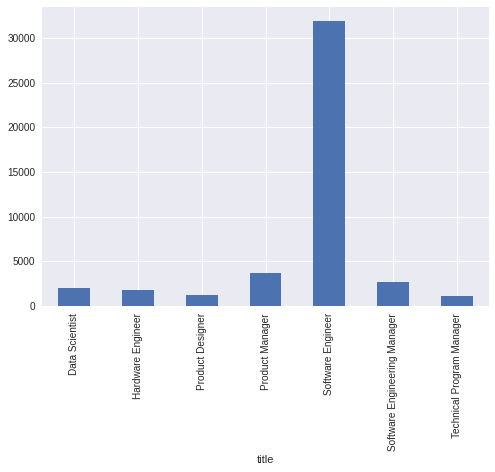

In [ ]:
for title in dropped_titles:
  df = df.drop(df[df['title'] == title].index)

df.groupby(["title"]).size().plot(kind="bar")

We also have a timestamp corresponding to the moment the data was written. We do not beleive that knowing the hour of the day or even the date is relevant as salaries tend to fluctuate over the years. Therefore we choose to only retain the year of the entire date.

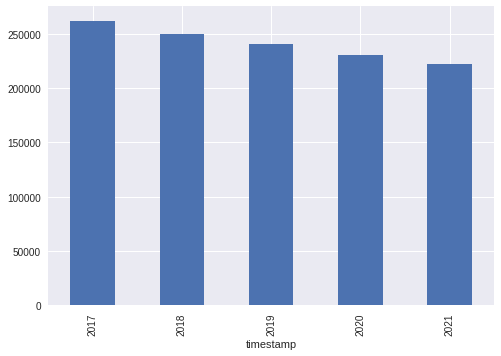

In [ ]:
df["timestamp"] = pd.to_datetime(df["timestamp"]).dt.year
df.groupby(["timestamp"])["totalyearlycompensation"].mean().plot(kind="bar")

As we want to study the impact of the features `gender`, `Race`, `Education`, we will need to drop the null values as we can't infer their values using other features of the dataset. This results in losing about two thirds of the data. We think 15k rows is still plenty enough.

In [ ]:
print(f"We had initially {df.shape[0]} rows including those with null values.")
df = df.dropna(subset=["gender", "Race", "Education"]).reset_index(drop=True)
print(f"We now are left with {df.shape[0]} rows")

We had initially 44356 rows including those with null values.
We now are left with 15357 rows


This is the **final dataset** we are going to work with.

In [ ]:
df.head()

,timestamp,company,title,totalyearlycompensation,yearsofexperience,yearsatcompany,gender,cityid,Race,Education,state
0,2020,google,Software Engineer,400000,1,1,Male,7472,Asian,PhD,CA
1,2020,microsoft,Software Engineer,136000,0,0,Male,11521,Two Or More,Bachelor's Degree,WA
2,2020,google,Software Engineer,337000,1,1,Male,7413,Asian,Bachelor's Degree,CA
3,2020,microsoft,Software Engineer,222000,0,0,Male,11527,Asian,Master's Degree,WA
4,2020,blend,Software Engineer,187000,1,0,Male,7419,White,Bachelor's Degree,CA


## Statistical analysis
A Small analysis of the salaries to help us select classes for our algorithms. We precise that all salaries are in US dollars. Salaries are annual.

In [ ]:
salaries = df["totalyearlycompensation"]

In [ ]:
pd.set_option('display.float_format', lambda x: '%.5f' % x) ##Display readable salaries
salaries.describe()

count     15357.00000
mean     213555.83773
std      129384.79005
min       10000.00000
25%      135000.00000
50%      187000.00000
75%      263000.00000
max     1300000.00000
Name: totalyearlycompensation, dtype: float64

Let's plot the distribution of the `totalyearlycompensation` throughout the dataset, we can expect a gaussian distribution if our data is balanced.

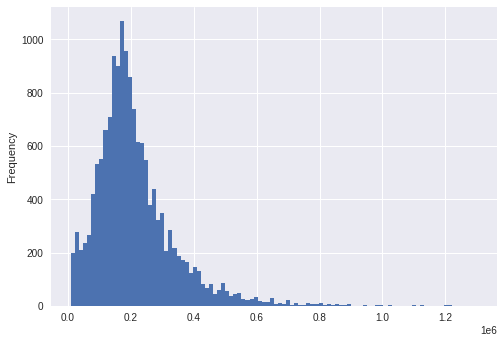

In [ ]:
salaries.plot.hist(bins=100)

As we can see, the data follows a bell shaped curve, caracteristic of the normal distribution.

Let's see if we can find an interesting pattern in `totalyearlycompensation` depending on the `timestamp` and `Race` and `gender`.

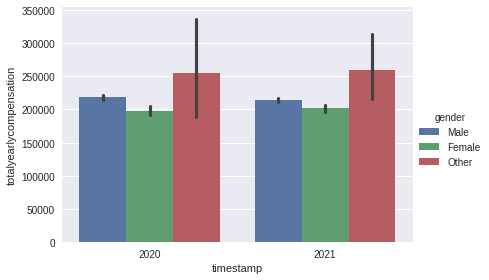

In [ ]:
sns.catplot(kind="bar", x="timestamp", y="totalyearlycompensation", hue="gender", data=df, height=4.0, aspect=12.0/8.0)

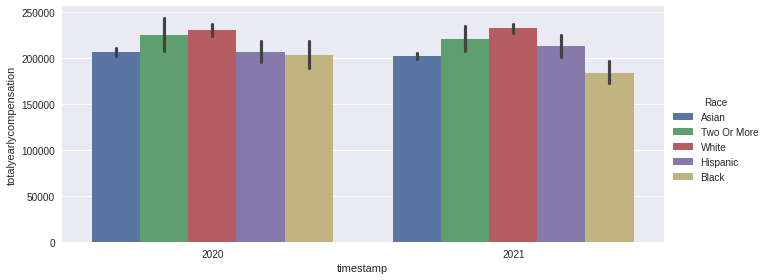

In [ ]:
sns.catplot(kind="bar", x="timestamp", y="totalyearlycompensation", hue="Race", data=df, height=4.0, aspect=19.0/8.0)

As we can see, since we dropped the null data, we only have data for 2020 and 2021. The differences between the two years are not very significant for our study, we can consider that the timestamp has no impact.

In [ ]:
np.quantile(salaries, 0.95).round()

450000.0

We see that the large majority of subjects earn less than 500K. 
Just by curiosity we computed the Gini index to see inequality among data-scientists. 

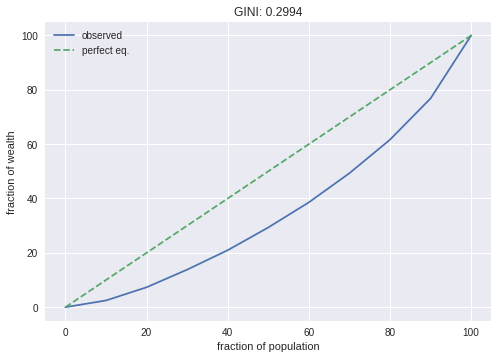

In [ ]:
def gini_index(v):
    bins = np.linspace(0., 100., 11)
    total = float(np.sum(v))
    yvals = []
    for b in bins:
        bin_vals = v[v <= np.percentile(v, b)]
        bin_fraction = (np.sum(bin_vals) / total) * 100.0
        yvals.append(bin_fraction)
    # perfect equality area
    pe_area = np.trapz(bins, x=bins)
    # lorenz area
    lorenz_area = np.trapz(yvals, x=bins)
    gini_val = (pe_area - lorenz_area) / float(pe_area)
    return bins, yvals, gini_val

bins, result, gini_val = gini_index(salaries)
plt.figure()
plt.plot(bins, result, label="observed")
plt.plot(bins, bins, '--', label="perfect eq.")
plt.xlabel("fraction of population")
plt.ylabel("fraction of wealth")
plt.title("GINI: %.4f" %(gini_val))
plt.legend()

With a GINI index of 0.299, the tech field is doing pretty well in term of equality, for instance France has a GINI of 32 which is considered equalitarian.

We want to get rid of the outilers (salaries between 500k and 1.2M) because they are not representative of the field. In fact we think that those high differences in incomes are due to hidden parrameters that we can not control, and that are not part of the dataset (such as high positions, maybe multiple positions, high responsibility jobs, specific competence such as mastering rare languages, etc...).

In [ ]:
## Exclude large values
max_salary = np.quantile(salaries, 0.95).round()
df = df[df["totalyearlycompensation"] < max_salary]
df.shape

(14557, 11)

We compute some descriptive statistics after the cleaning of the upper 5% of salaries.

In [ ]:
salaries = df["totalyearlycompensation"]
pd.set_option('display.float_format', lambda x: '%.5f' % x) ##Display readable salaries
salaries.describe()

count    14557.00000
mean    192987.42873
std      91192.32140
min      10000.00000
25%     131000.00000
50%     181000.00000
75%     247000.00000
max     449000.00000
Name: totalyearlycompensation, dtype: float64

Let's now study the distribution of wealth between genders accross the dataset

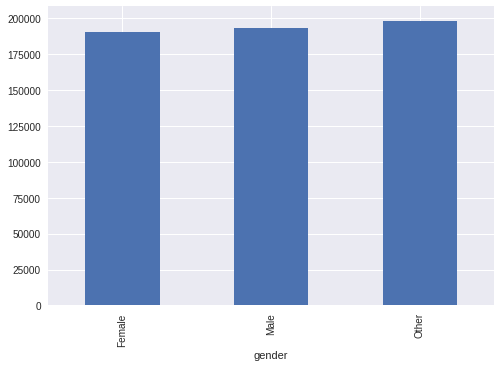

In [ ]:
df.groupby(["gender"])["totalyearlycompensation"].mean().plot(kind="bar")
plt.show()

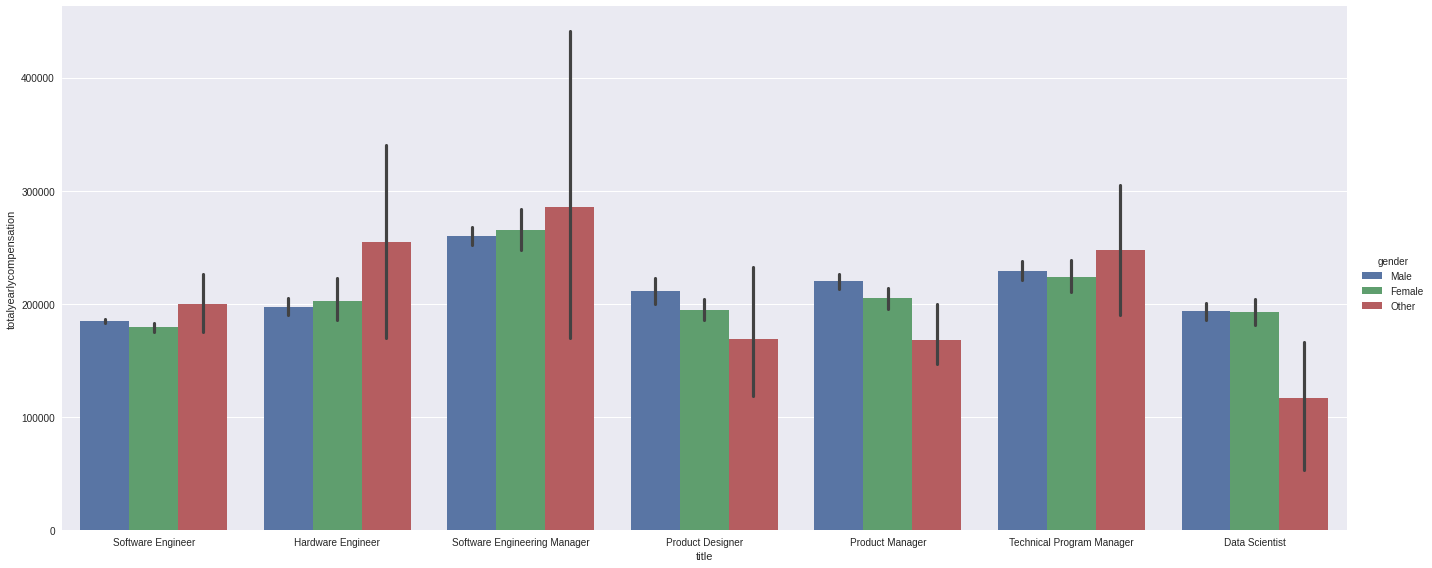

In [ ]:
sns.catplot(kind="bar", x="title", y="totalyearlycompensation", hue="gender", data=df, height=8.0, aspect=19.0/8.0)

In this graph, the gender gap is not apparent, maybe the field of tech is more equalitarian accross gender. The `Other` option has a high variability and we can assume some of the population it is composed of are men and women who did not disclose their gender. This makes the analysis more difficult and we might not be able to draw conclusions regarding gender inequalities.

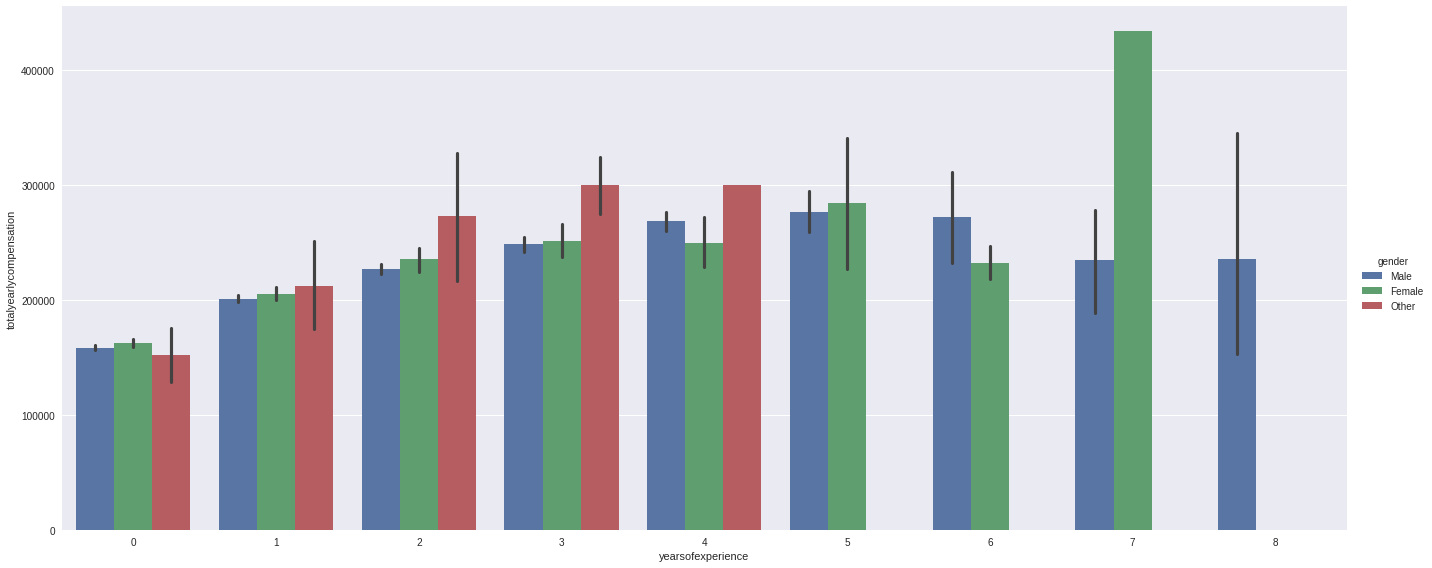

In [ ]:
sns.catplot(kind="bar", x="yearsofexperience", y="totalyearlycompensation", hue="gender", data=df, height=8.0, aspect=19.0/8.0)

We can also compute a graph who show the distribution of salary depending on the location.

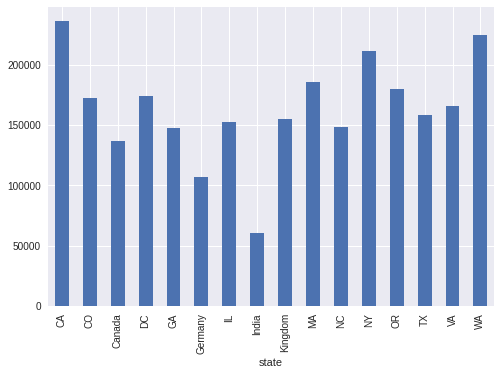

In [ ]:
df.groupby(["state"])["totalyearlycompensation"].mean().plot(kind="bar")
plt.show()

For race Asian, there are 6234 Software Engineers
For race Black, there are 293 Software Engineers
For race Hispanic, there are 491 Software Engineers
For race Two Or More, there are 357 Software Engineers
For race White, there are 3178 Software Engineers


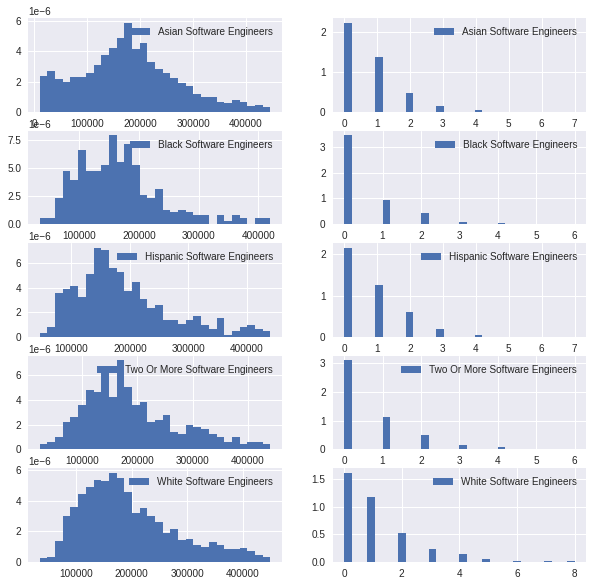

For race Asian, there are 410 Hardware Engineers
For race Black, there are 13 Hardware Engineers
For race Hispanic, there are 15 Hardware Engineers
For race Two Or More, there are 22 Hardware Engineers
For race White, there are 122 Hardware Engineers


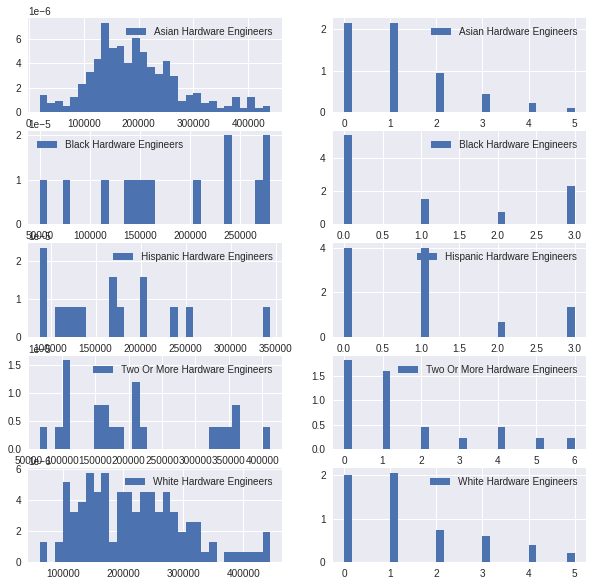

For race Asian, there are 334 Software Engineering Managers
For race Black, there are 15 Software Engineering Managers
For race Hispanic, there are 30 Software Engineering Managers
For race Two Or More, there are 19 Software Engineering Managers
For race White, there are 255 Software Engineering Managers


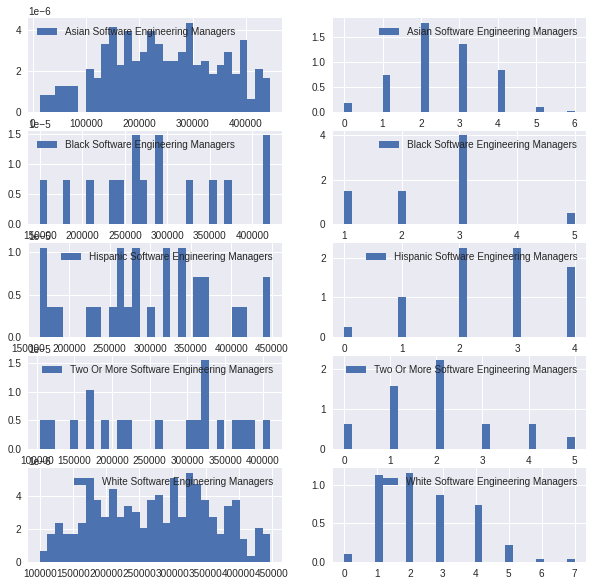

For race Asian, there are 211 Product Designers
For race Black, there are 25 Product Designers
For race Hispanic, there are 25 Product Designers
For race Two Or More, there are 27 Product Designers
For race White, there are 190 Product Designers


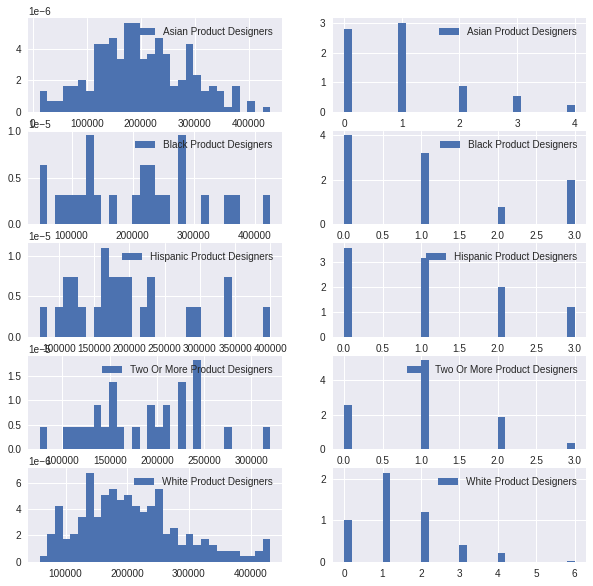

For race Asian, there are 552 Product Managers
For race Black, there are 42 Product Managers
For race Hispanic, there are 58 Product Managers
For race Two Or More, there are 45 Product Managers
For race White, there are 408 Product Managers


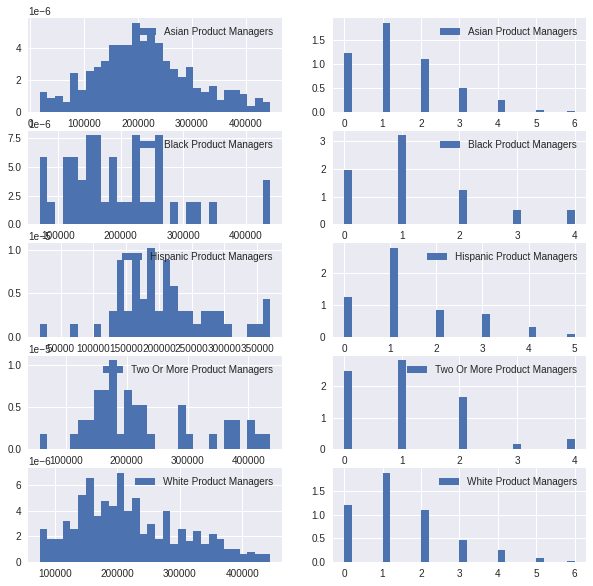

For race Asian, there are 258 Technical Program Managers
For race Black, there are 23 Technical Program Managers
For race Hispanic, there are 19 Technical Program Managers
For race Two Or More, there are 24 Technical Program Managers
For race White, there are 180 Technical Program Managers


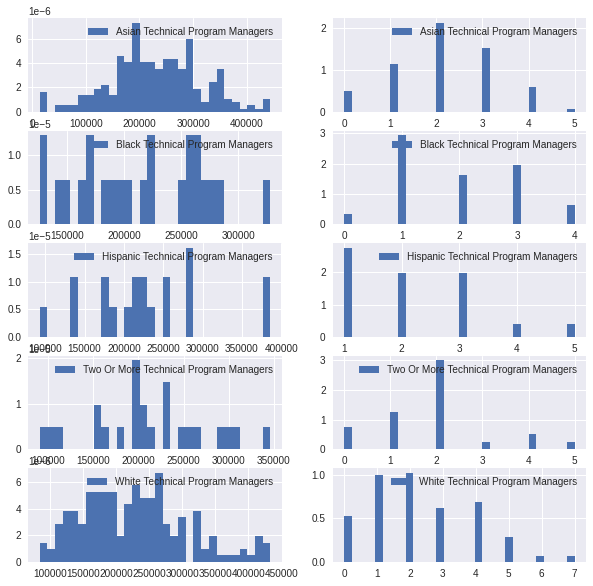

For race Asian, there are 412 Data Scientists
For race Black, there are 9 Data Scientists
For race Hispanic, there are 25 Data Scientists
For race Two Or More, there are 22 Data Scientists
For race White, there are 214 Data Scientists


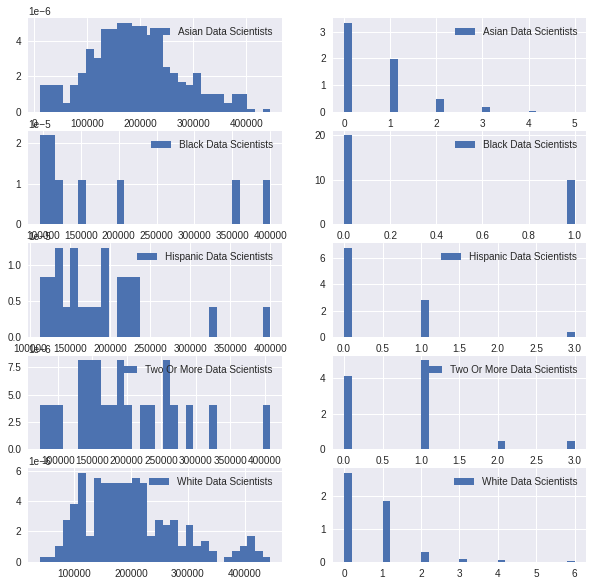

In [ ]:
for title in df['title'].unique():
  races = df[df['title'] == title].groupby(['Race'])
  fig, ax = plt.subplots(5, 2, figsize=(10,10))
  for i, (raceKey, raceGrp) in enumerate(races):
      print(f"For race {raceKey}, there are {raceGrp.shape[0]} {title}s")
      ax[i][0].hist(raceGrp['totalyearlycompensation'], bins=30, label=f"{raceKey} {title}s", density=True)
      ax[i][0].legend()

      ax[i][1].hist(raceGrp['yearsofexperience'], bins=30, label=f"{raceKey} {title}s", density=True)
      ax[i][1].legend()

  plt.show()

We will study the importance of factors such as race or the year (regarding the pandemic and other economics factors).

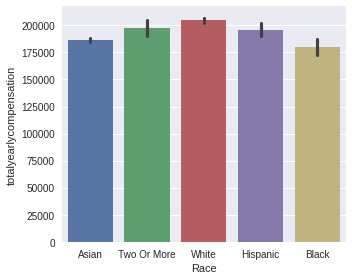

In [ ]:
sns.catplot(kind="bar", x="Race", y="totalyearlycompensation", data=df, height=4.0, aspect=10.0/8.0)

Here, we can clearly see that race has something to do with revenue. Even though there is some variability, Black people tend to earn less than White people. But our data comes from various countries and there could be a bias, we need further analysis before drawing conclusions.

Let's try to see if the years of experience of an employee corelates with its total yearly compensation

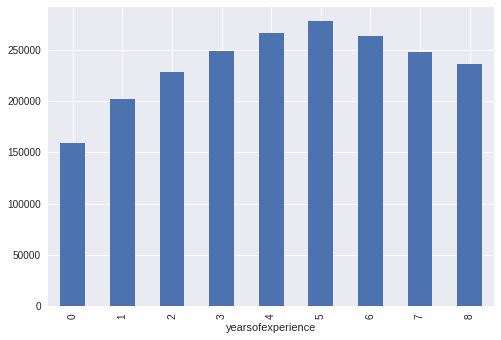

In [ ]:
software_engineers = (df[df['title'] == 'Software Engineer'])
df.groupby(['yearsofexperience']).mean()["totalyearlycompensation"].plot(kind='bar')
plt.show()

As we can see, the `totalyearlycompensation` is correlated to the `yearsofexperience`, but not in the way we could have expected. The more experience you have, the more you will earn until a given threshold, then you start to earn less. It can be explained by companies being reluctant to hire older people that maybe have more deprecated skills.

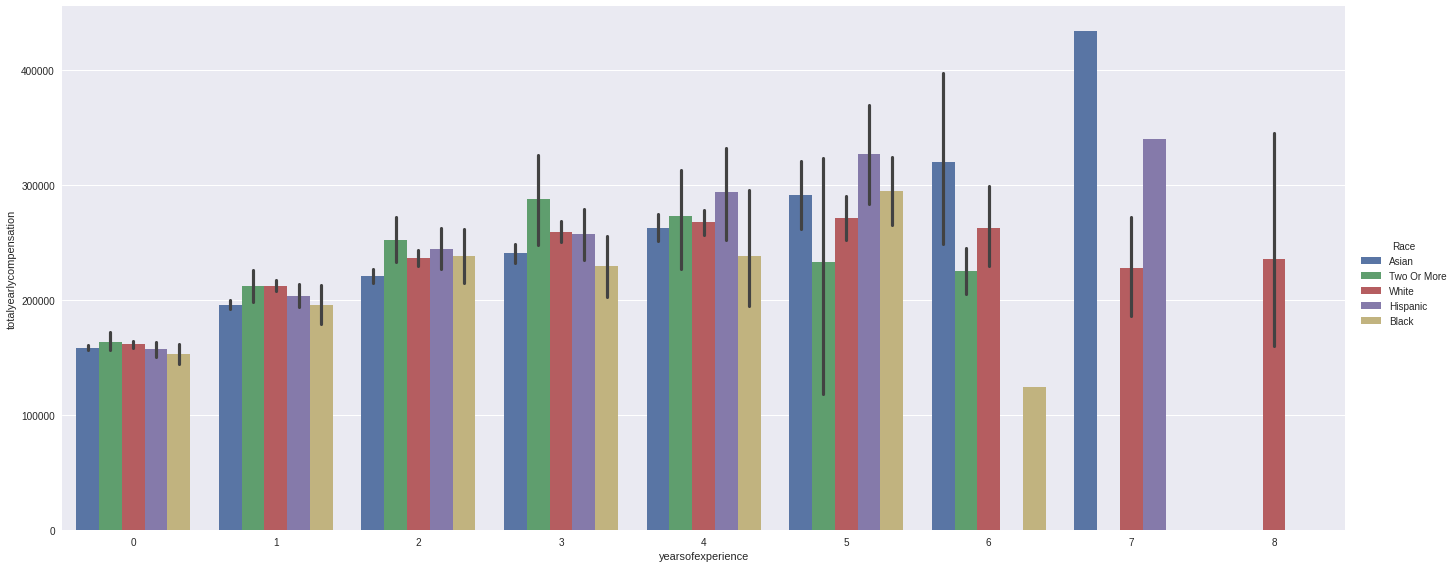

In [ ]:
sns.catplot(kind="bar", x="yearsofexperience", y="totalyearlycompensation", hue="Race", data=df, height=8.0, aspect=19.0/8.0)

In this graph, it seems black people earn consistently less than their white counterparts accross the different tranches of experiences, but the high variability prevents us from drawing a conclusion.

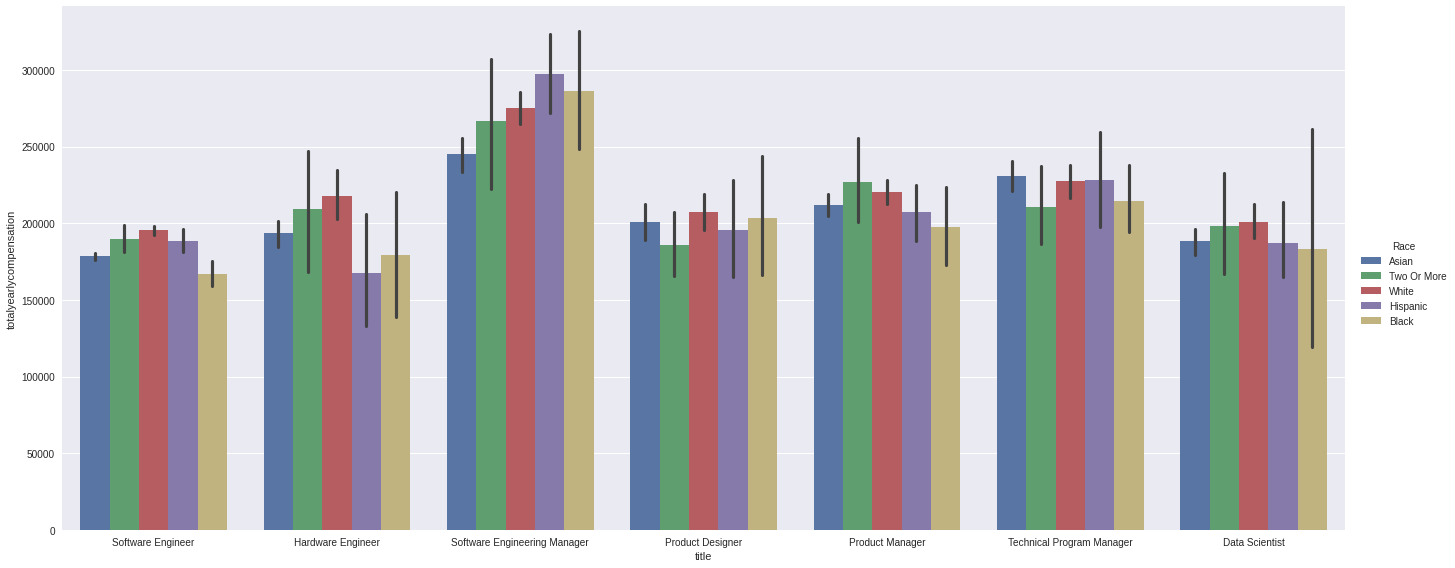

In [ ]:
sns.catplot(kind="bar", x="title", y="totalyearlycompensation", hue="Race", data=df, height=8.0, aspect=19.0/8.0)

This graph were we compare the remuneration to the `title` as well paints the same picture, and with the same annoying variability.

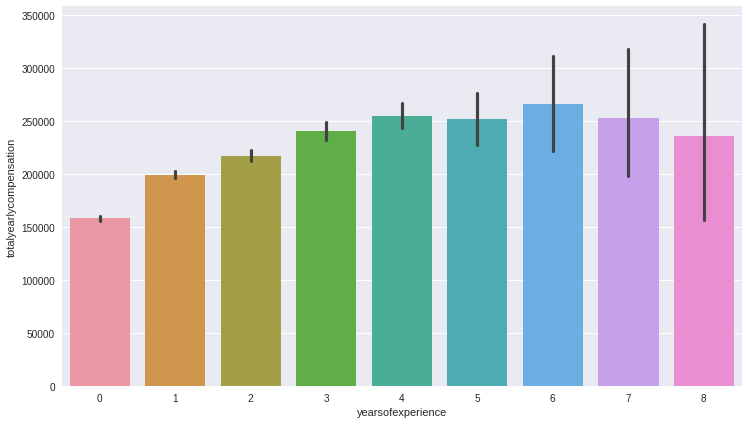

In [ ]:
software_engineers = (df[df['title'] == 'Software Engineer'])
sns.catplot(kind="bar", x="yearsofexperience", y="totalyearlycompensation", data=software_engineers, height=6.0, aspect=14.0/8.0)

This is not the result we expected (results are very similar even when keeping extreme values), but still experience has a real impact on salary, which is to be expected.

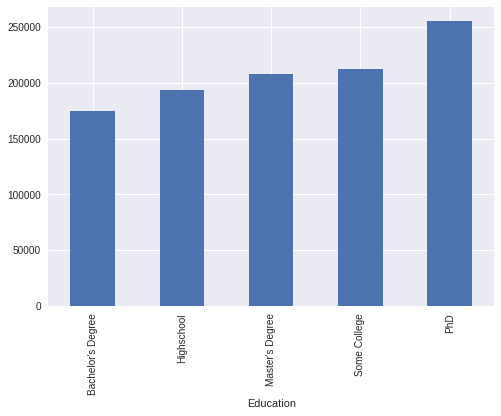

In [ ]:
df.groupby(['Education']).mean()["totalyearlycompensation"].sort_values().plot(kind='bar')

In [ ]:
#df[df.groupby(['company']).size() > 100].groupby(["company"]).size().plot(kind="bar")

In conclusion, we have seen that there is a relation between `Race` and salaries, level of `Education` and salaries, and `gender` and salaries. We also found bonds between `years of experience` and the salaries. It is not clear if these are true corellation, but we can still use these patterns for prediction purposes.

## Data spliting

First we will shuffle the dataset to remove the biases that could be caused by the order of the rows. This might help with overfitting.

In [ ]:
df = df.sample(frac=1)

We split the data to get a train and a test set.

In [ ]:
def train_test_split(data: pd.DataFrame, target_key:str, percent_test:int):
    #Separate training and testing sets
    training = data.iloc[0:round(len(data)*(1-percent_test/100))]
    testing = data.iloc[round(len(data)*(1-percent_test/100)):]

    #Separate X and y
    y_train = training[target_key]
    X_train = training.drop(target_key,axis=1)

    y_test = testing[target_key]
    X_test = testing.drop(target_key,axis=1)
    
    return X_train, y_train, X_test, y_test


## Scoring
Let's create a basic score to evaluate the performances of our different models. For example : the average relative error of the prediction.

In [ ]:
def error(prediction, y_test):
  return abs((prediction - y_test) / y_test).mean()

In [ ]:
def mse(prediction, y_test):
  return ((prediction - y_test) ** 2).mean()

In [ ]:
def error_mean(preds, y_test, m:float):
  a = preds > m
  b = y_test > m
  return np.mean(a=b)

## Creating classes
We create tranches of salary instead of just guessing the exact number. 

First we need to tokenize some of our features as we can only work with numbers.

In [ ]:
## Labeling
from sklearn.preprocessing import LabelEncoder
to_label = ["company", "title", "gender", "Race", "Education", "state"]
data = df.copy(deep=True)
for label in to_label:
  data[label] = LabelEncoder().fit_transform(data[label])

# as the statistical anaylsis demonstrated, we can get rid of the timestamp
df.drop(["timestamp"], axis=1, inplace=True)

data.head()

,timestamp,company,title,totalyearlycompensation,yearsofexperience,yearsatcompany,gender,cityid,Race,Education,state
9272,2021,886,3,138000,0,0,1,7369,4,0,0
5434,2021,605,4,410000,2,1,1,7434,0,2,0
12526,2021,868,4,80000,0,0,1,1206,0,0,2
7660,2021,829,0,372000,0,0,1,7419,4,2,0
8805,2021,666,1,193000,0,0,1,7304,0,3,0


Guessing the exact salary is not what we want to achieve. We would have better performance with salary tranches, then we can predict the tranch of a given person.

In [ ]:
def tranche(salary:float, tranches:np.array):
  i = 0
  while i < len(tranches) and salary >= tranches[i]:
    i+=1
  return i ## We want a strictly positive number so i is in 1, len(tranches) + 1

In [ ]:
def classify(data:pd.DataFrame, n_classes):
  tranches = np.linspace(0, max_salary, n_classes)
  data["totalyearlycompensation"] = data["totalyearlycompensation"].apply(lambda x: tranche(x, tranches))


## Prediction

We will use different prediction methods seen in the SD201 course. We think that classification is the best fitted tool to get to our goal, as we have determining features. We will try to predict the salary tranch using the features we selected from the statistical analysis.

### Decision tree classification

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
def tree_classification(m_depth:int, n_tranches:int, p_test:int):

  df_copy = data.copy(deep=True)

  if n_tranches > 0:
    classify(df_copy, n_tranches)

  X_train, y_train, X_test, y_test = train_test_split(df_copy, target_key="totalyearlycompensation", percent_test=p_test)

  X_valid, y_valid = X_train[0:1000], y_train[0:1000]

  dt = DecisionTreeClassifier(max_depth=m_depth)
  dt.fit(X_train, y_train)
  
  dt_valid_preds = dt.predict(X_valid)
  dt_test_preds = dt.predict(X_test)

  fig = plt.figure(figsize=(25,20))
  _ = sklearn.tree.plot_tree(dt,
                   filled=True)


  print("Error on validation set:", error(dt_valid_preds, y_valid).round(5))
  print("Error on test set:", error(dt_test_preds, y_test).round(5))

  print("MSE on validation set:", mse(dt_valid_preds, y_valid).round(5))
  print("MSE on test set:", error(dt_test_preds, y_test).round(5))

Error on validation set: 0.1755
Error on test set: 0.19788
MSE on validation set: 0.284
MSE on test set: 0.19788


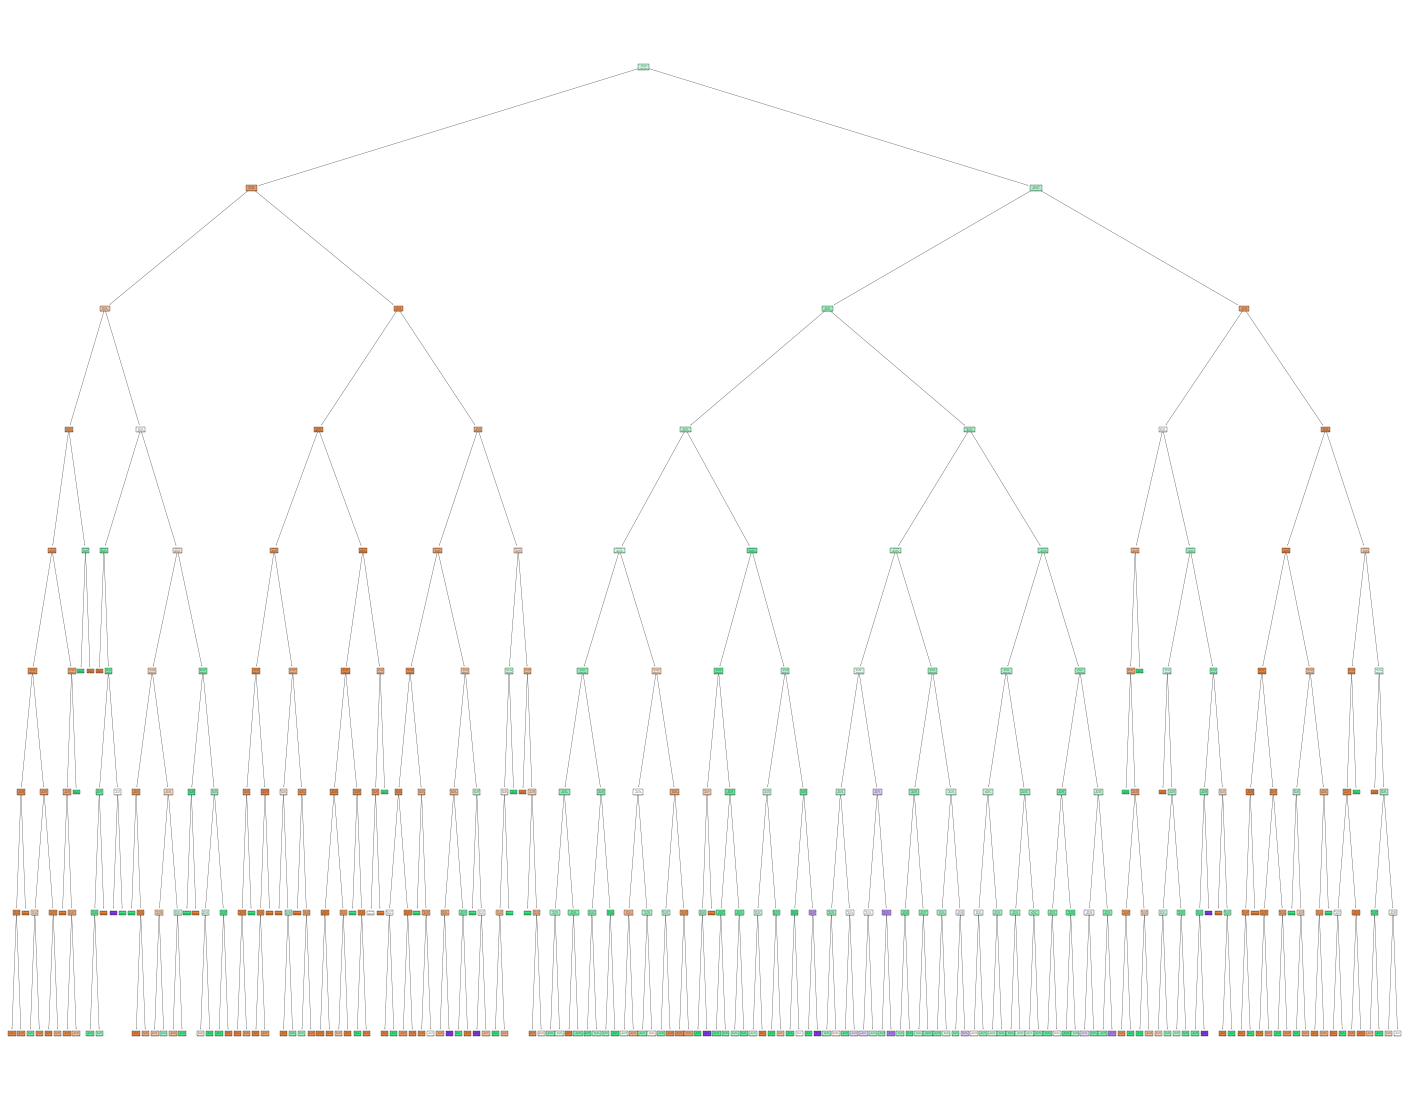

In [ ]:
tree_classification(m_depth=8, n_tranches=4, p_test=15)

As expected, when using tranches of revenue, the results are way better (The error went down from 0.35 to 0.17). The fewer the tranches, the better the score is, which makes sense. There is a tradeoff between precision (the size of revenue tranches) and the reliability of the classifier, and by empirical tweaking the sweet spot appears to be 4 tranches. This is still better than state of the art examples choosing to classify according to a one value level (for example revenues greater or lower than 50k, 100k...).

### Random Forest classification.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
def rf_classification(n_est:int, n_tranches: int, p_test:int):

  df_copy = data.copy(deep=True)

  if n_tranches > 0:
    classify(df_copy, n_tranches)

  X_train, y_train, X_test, y_test = train_test_split(df_copy, target_key="totalyearlycompensation", percent_test=p_test)

  X_valid, y_valid = X_train[0:1000], y_train[0:1000]

  rf = RandomForestClassifier(n_estimators=n_est, max_features=9, max_depth=4)
  rf.fit(X_train, y_train)

  rf_valid_preds = rf.predict(X_valid)
  rf_test_preds = rf.predict(X_test)

  print(f"Error on validation set: {error(rf_valid_preds, y_valid).round(5)}")
  print(f"Error on test set: {error(rf_test_preds, y_test).round(5)}")

  print("MSE on validation set:", mse(rf_valid_preds, y_valid).round(5))
  print("MSE on test set:", error(rf_test_preds, y_test).round(5))

  return error(rf_test_preds, y_test)

In [ ]:
rf_classification(n_est=20, n_tranches=4, p_test=15)

Error on validation set: 0.02417
Error on test set: 0.16369
MSE on validation set: 0.042
MSE on test set: 0.16369


0.1636904761904762

We expected a significatively better score with a random forest. We also see some overfitting that we will look into in the future. We get a similar score relative to tree classification. 
Tweaking the max_depht only resulted in a decrease in the accuracy so we decided not to touch it. 
Trying to cap the number of features we only got worse results as well. The best option (by a very narrow margin) was to set the max feature number to the total number of features.

We assess the importance of $\texttt{n_est}$ .

[10, 20, 30, 40, 50, 60, 70, 80, 90]


 11%|█         | 1/9 [00:00<00:02,  3.08it/s]

Error on validation set: 0.03183
Error on test set: 0.16934
MSE on validation set: 0.058
MSE on test set: 0.16934


 22%|██▏       | 2/9 [00:00<00:03,  2.12it/s]

Error on validation set: 0.0265
Error on test set: 0.16033
MSE on validation set: 0.044
MSE on test set: 0.16033


 33%|███▎      | 3/9 [00:01<00:03,  1.58it/s]

Error on validation set: 0.0205
Error on test set: 0.16339
MSE on validation set: 0.033
MSE on test set: 0.16339


 44%|████▍     | 4/9 [00:02<00:04,  1.22it/s]

Error on validation set: 0.02417
Error on test set: 0.16094
MSE on validation set: 0.04
MSE on test set: 0.16094


 56%|█████▌    | 5/9 [00:04<00:04,  1.03s/it]

Error on validation set: 0.0275
Error on test set: 0.16209
MSE on validation set: 0.044
MSE on test set: 0.16209


 67%|██████▋   | 6/9 [00:05<00:03,  1.23s/it]

Error on validation set: 0.02067
Error on test set: 0.16316
MSE on validation set: 0.035
MSE on test set: 0.16316


 78%|███████▊  | 7/9 [00:07<00:02,  1.44s/it]

Error on validation set: 0.02217
Error on test set: 0.1598
MSE on validation set: 0.037
MSE on test set: 0.1598


 89%|████████▉ | 8/9 [00:09<00:01,  1.66s/it]

Error on validation set: 0.025
Error on test set: 0.15583
MSE on validation set: 0.041
MSE on test set: 0.15583


100%|██████████| 9/9 [00:12<00:00,  1.36s/it]

Error on validation set: 0.02267
Error on test set: 0.16468
MSE on validation set: 0.037
MSE on test set: 0.16468


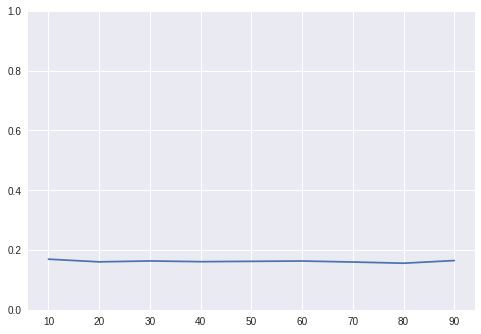

In [ ]:
N = list(np.arange(10,100,10))
print(N)
error_list = []
for n in tqdm(N):
  s = rf_classification(n_est=n, n_tranches=4, p_test=15)
  error_list.append(s)

plt.plot(N, error_list)
plt.ylim(0,1)
plt.show()

Adding more trees does nothing. 

### K-nearest Neighbours

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
def kNN_classification(n_neigh:int, n_tranches: int, p_test:int):
  df_copy = data.copy(deep=True)

  if n_tranches > 0:
    classify(df_copy, n_tranches)
  
  X_train, y_train, X_test, y_test = train_test_split(df_copy, target_key="totalyearlycompensation", percent_test=p_test)

  kNN = KNeighborsClassifier(n_neighbors=n_neigh, metric='correlation')
  kNN.fit(X_train, y_train)
  kNN_preds = kNN.predict(X_test)

  #print("Error :", error(kNN_preds, y_test).round(5))
  return error(kNN_preds, y_test).round(5)
  



k is set to :  120


100%|██████████| 120/120 [01:28<00:00,  1.36it/s]


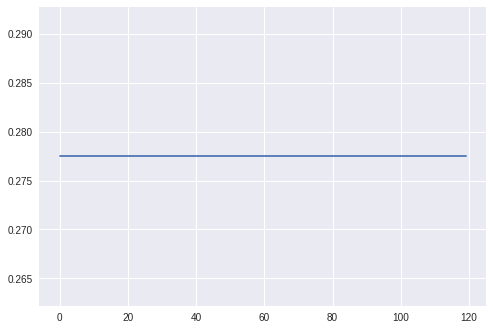

In [ ]:
k_n = int(np.sqrt(df.shape[0]))
print("k is set to : ", k_n)
X = list(range(k_n))
scores_list = []
for k in tqdm(X):
  s = kNN_classification(n_neigh=k_n, n_tranches=10, p_test=15)
  scores_list.append(s)

plt.plot(X, scores_list)

Base results (no tweaking) for kNN was better than tree classification base results. The problem is choosing the best fitting metric. A basic geometrical metric makes no sense as it computes the distance between label integers that are not necessarly choosen regarding feature proximity. 
An idea is to take a norm that simply checks the similarity between two vectors. 
Changing the k parameter did virtually nothing, so we can conclude that this methode is not very relevant for our problem.


## Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
def lr_classification(n_tranches:int, p_test:int):

  df_copy = data.copy(deep=True)

  if n_tranches > 0:
    classify(df_copy, n_tranches)

  X_train, y_train, X_test, y_test = train_test_split(df_copy, target_key="totalyearlycompensation", percent_test=p_test)

  X_valid, y_valid = X_train[0:1000], y_train[0:1000]

  lr = LogisticRegression()
  lr.fit(X_train, y_train)
  
  lr_valid_preds = lr.predict(X_valid)
  lr_test_preds = lr.predict(X_test)


  print("Error on validation set:", error(lr_valid_preds, y_valid).round(5))
  print("Error on test set:", error(lr_test_preds, y_test).round(5))

  print("MSE on validation set:", mse(lr_valid_preds, y_valid).round(5))
  print("MSE on test set:", error(lr_test_preds, y_test).round(5))

In [ ]:
lr_classification(n_tranches=4, p_test=15)

Error on validation set: 0.33667
Error on test set: 0.3473
MSE on validation set: 0.439
MSE on test set: 0.3473


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


## Linear regression

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
def lnr_classification(n_tranches:int, p_test:int):

  df_copy = data.copy(deep=True)

  if n_tranches > 0:
    classify(df_copy, n_tranches)

  X_train, y_train, X_test, y_test = train_test_split(df_copy, target_key="totalyearlycompensation", percent_test=p_test)

  X_valid, y_valid = X_train[0:1000], y_train[0:1000]

  lnr = LinearRegression()
  lnr.fit(X_train, y_train)
  
  lnr_valid_preds = lnr.predict(X_valid)
  lnr_test_preds = lnr.predict(X_test)


  print("Error on validation set:", error(lnr_valid_preds, y_valid).round(5))
  print("Error on test set:", error(lnr_test_preds, y_test).round(5))

  print("MSE on validation set:", mse(lnr_valid_preds, y_valid).round(5))
  print("MSE on test set:", error(lnr_test_preds, y_test).round(5))

In [ ]:
lnr_classification(n_tranches=5, p_test=15)

Error on validation set: 0.33429
Error on test set: 0.33629
MSE on validation set: 0.57637
MSE on test set: 0.33629


## Gradient boosted trees

As we already tried the decision tree and the random forest, obtaining similar results, we need to find another algorithm if we want to lower our error. Gradient boosting is an improvement over the random forest and is as relevant for our problem since their usecase is the same. We expect better results than with the random forest.Gradient boosting generates a set of predictors and like the random forest, we aggregate the results of all the weak predictors to get (we hope), a strong prediction.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
def gb_classification(m_depth:int, n_tranches:int, n_est:int, p_test:int):

  df_copy = data.copy(deep=True)

  if n_tranches > 0:
    classify(df_copy, n_tranches)

  X_train, y_train, X_test, y_test = train_test_split(df_copy, target_key="totalyearlycompensation", percent_test=p_test)

  X_valid, y_valid = X_train[0:1000], y_train[0:1000]

  gb = GradientBoostingClassifier(n_estimators=n_est, max_depth=m_depth, validation_fraction=0.2)
  gb.fit(X_train, y_train)
  
  gb_valid_preds = gb.predict(X_valid)
  gb_test_preds = gb.predict(X_test)


  print("Error on validation set:", error(gb_valid_preds, y_valid).round(5))
  print("Error on test set:", error(gb_test_preds, y_test).round(5))

  print("MSE on validation set:", mse(gb_valid_preds, y_valid).round(5))
  print("MSE on test set:", error(gb_test_preds, y_test).round(5))

In [ ]:
gb_classification(m_depth=5, n_tranches=5, n_est = 50, p_test=15)

Error on validation set: 0.14258
Error on test set: 0.17479
MSE on validation set: 0.352
MSE on test set: 0.17479


We can see that the Gradient boosting did a little better than the decision tree and the random forest. But the improvement is only about 2%, it seems our data is holding back our models. It did not overfit as much as the random forest though

## AutoML

We thing we can also try is AutoML, which is an AI used to determine the most suitable classification method for a given dataset, and tune the hyperparameters. Unfortunately, we did not manage to make it run on our data.

In [1]:
!pip install auto-sklearn

exec: Failed to execute process '/opt/homebrew/bin/pip': The file specified the interpreter '/opt/homebrew/opt/python@3.11/bin/python3.11', which is not an executable command.


In [2]:
import autosklearn.classification

ModuleNotFoundError: No module named 'autosklearn'

In [ ]:
def cls_classification(n_tranches:int, p_test:int):

  df_copy = data.copy(deep=True)

  if n_tranches > 0:
    classify(df_copy, n_tranches)

  X_train, y_train, X_test, y_test = train_test_split(df_copy, target_key="totalyearlycompensation", percent_test=p_test)

  X_valid, y_valid = X_train[0:1000], y_train[0:1000]

  cls = autosklearn.classification.AutoSklearnClassifier()
  cls.fit(X_train, y_train)
  
  cls_valid_preds = cls.predict(X_valid)
  cls_test_preds = cls.predict(X_test)


  print("Error on validation set:", error(cls_valid_preds, y_valid).round(5))
  print("Error on test set:", error(cls_test_preds, y_test).round(5))

In [ ]:
cls_classification(n_tranches=4, p_test=15)